# Определение стоимости автомобилей

**Описание проекта:**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель проекта:**

Разработать модель машинного обучения для предсказания рыночной стоимости автомобилей по их характеристикам, учитывая качество предсказаний (RMSE < 2500), а также скорость обучения и предсказания модели.

**Ход исследования:**

- [Загрузка данных](#загрузка) – откроем файл /datasets/autos.csv и изучим его.
- [Предобработка данных](#предобработка) – обработаем пропуски, аномалии и удалим неинформативные признаки.
- [Подготовка данных](#подготовка) – разделим выборки на обучающую, валидационную и тестовую.
- [Обучение моделей](#обучение) – протестируем разные алгоритмы, включая `LightGBM`, `RndomForestRegressor` и не-бустинговую модель `LinearRegression`.
- [Анализ моделей](#анализ) – оценим RMSE, время обучения и предсказания и выберем наиболее подходящую по критериям заказчика.
- [Общий вывод](#общий)

**Описание данных:**

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
-`PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**
- `Price` — цена (евро)

<a id='загрузка'></a>
## Загрузка данных
**Загрузка билиотек и модулей:**

In [1]:
# Установим LightGBM
!pip install lightgbm -q

In [2]:
import time
import lightgbm
import numpy as np 
import pandas as pd   
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV  

**Загрузка данных:**

In [3]:
df = pd.read_csv('/datasets/autos.csv')

In [4]:
# Проверим первые 10 строк
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
# Проверка основной и статистической информации
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


- В параметрах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired` есть пропуски, вохможно эти поля были необязательны к заполнению.
- Похоже в параметре `Power` есть выбросы, так как максимальное значение больше третьего квартиля в 13 раз, а в параметре `Price` максимальное значение больше третьего квартиля в три раза. `В RegistrationYear` указан минимальный год 1000, а макс 9999 нужно порверить выбросы.
- Ненужные параметры, которые не влияют на целевой признак нужно удалить: `DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`.

<a id='предобработка'></a>
## Предобработка данных

In [6]:
# Посмотрим вначале дату выгрузки анкет, преобразовав ее вначале в формат datetime
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])
print(df['DateCrawled'].min(), df['DateCrawled'].max())

2016-03-05 14:06:22 2016-04-07 14:36:58


In [7]:
# Проверим дубликаты
df.duplicated().sum()

4

In [8]:
# Удаляем дубликаты
df.drop_duplicates(inplace=True)

In [9]:
# Проверим долю пропусков
df.isna().mean() * 100

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579487
RegistrationYear      0.000000
Gearbox               5.596772
Power                 0.000000
Model                 5.560651
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282802
Brand                 0.000000
Repaired             20.079297
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

In [10]:
# Проверим уникальные значения параметра VehicleType
df['VehicleType'].value_counts()

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [11]:
# Заменим пропуски на other
df['VehicleType'].fillna('other', inplace=True)

In [12]:
# Проверим уникальные значения Gearbox
df['Gearbox'].value_counts()

manual    268249
auto       66283
Name: Gearbox, dtype: int64

In [13]:
# Тогда заменим пропуски на unknown
df['Gearbox'].fillna('unknown', inplace=True)

In [14]:
# Проверим уникальные значения Model
df['Model'].value_counts()

golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

In [15]:
# Тогда заменим пропуски на other
df['Model'].fillna('other', inplace=True)

In [16]:
# Проверим уникальные значения FuelType
df['FuelType'].value_counts()

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [17]:
# Переименуем gasoline в petrol, поскольку оба означают "бензин"
df['FuelType'] = df['FuelType'].replace(['gasoline'], 'petrol')

# Заполним пропуски значением other
df['FuelType'].fillna('other', inplace=True)

In [18]:
# Заполним пропуски значением other в параметре Repaired
df['Repaired'].fillna('other', inplace=True)

In [19]:
# Повторная проверка пропусков
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [20]:
# Проверим уникальные значения RegistrationYear
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [21]:
# Удалим данные до 1900 и после 2016
df = df.loc[(df['RegistrationYear'] <= 2016) & (df['RegistrationYear'] >= 1900)]

# Снова проверим уникальные значения RegistrationYear
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 1997, 1990, 1981, 2003, 1994, 1991, 1984,
       2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989, 2015,
       1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1970, 1965,
       1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977, 1961, 1960,
       1966, 1975, 1963, 1964, 1954, 1958, 1967, 1959, 1956, 1941, 1962,
       1929, 1957, 1940, 1949, 1937, 1951, 1953, 1933, 1950, 1948, 1952,
       1932, 1942, 1935, 1936, 1923, 1930, 1944, 1943, 1934, 1938, 1928,
       1919, 1931, 1915, 1920, 1947, 1927, 1946])

У нас разный возраст машин. Есть гипотеза, что для разных возрастов - своё ценообразование. Поэтому определим возраст машин и посмотрим на распределение, чтобы выделить категории для нового параметра.

In [22]:
# Преобразуем RegistrationYear в datetime
df['RegistrationYear'] = pd.to_datetime(df['RegistrationYear'], format='%Y')

# Вводим новый признак Age (теперь вычитаем datetime из datetime)
df['Age'] = (df['DateCrawled'] - df['RegistrationYear']).dt.days / 365.25 # в годах

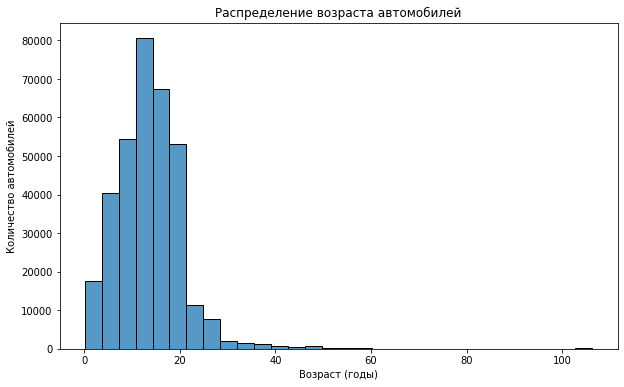

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=30)  # bins - количество интервалов
plt.title('Распределение возраста автомобилей')
plt.xlabel('Возраст (годы)')
plt.ylabel('Количество автомобилей')
plt.show()

- Выраженный пик в диапазоне 0-20 лет, значит большинство автомобилей в выборке относительно "молодые".
- Несколько менее выраженных пиков или подъемов можно заметить в районе 20-40 лет и далее.
- Длинный "хвост" вправо, что указывает на наличие небольшого количества автомобилей очень почтенного возраста.

In [24]:
# Создадим новые категории для Age
bins = [0, 4, 8, 12, 21, 31, df['Age'].max()]  # Границы категорий
labels = ['new', 'fresh', 'used', 'used +', 'old', 'retro']  # Названия категорий

df['Age'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

Тогда удалим RegistrationYear, чтобы избежать мультиколлеарности.

In [25]:
df = df.drop('RegistrationYear', axis=1)

In [26]:
# Повторная проверка пропусков
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
Age                  1
dtype: int64

In [27]:
# Удаляем строки с пропущенными значениями в столбце 'Age'
df.dropna(subset=['Age'], inplace=True)

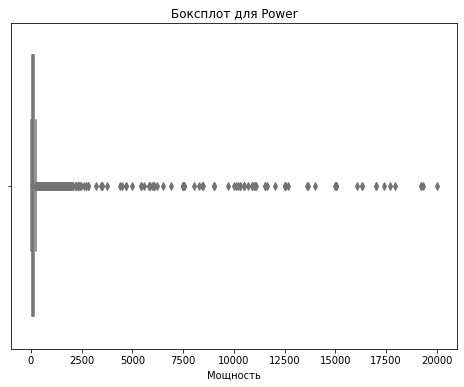

In [28]:
# Проверим параметр Power на выбросы с помощью Боксплот
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Power'], color='lightgreen')

plt.title('Боксплот для Power')
plt.xlabel('Мощность')
plt.show()

In [29]:
# Заполняем 0 медианой
df['Power'] = df['Power'].mask(df['Power'] == 0, df['Power'].median())

In [30]:
# Теперь ограничим данные до 1000 л.с., так как значения выше это суперкары, и аномалий
# Удаляем значения выше 1500
df = df.query('Power <= 1000')

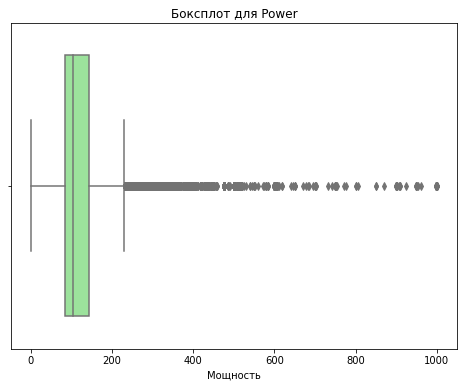

In [31]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Power'], color='lightgreen')

plt.title('Боксплот для Power')
plt.xlabel('Мощность')
plt.show()

<AxesSubplot:>

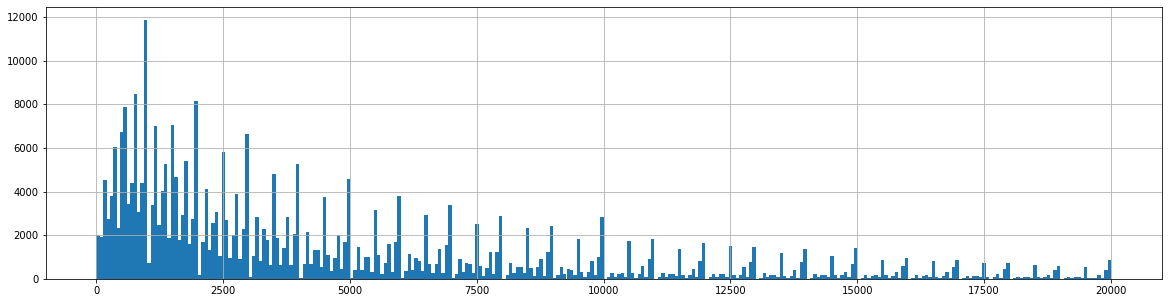

In [32]:
# Удалим 0 из целевого признака
df = df.query('Price > 0')

# Посмотрим на распределение целевого признака 
df['Price'].hist(bins=300, figsize=(20,5))

<function matplotlib.pyplot.show(close=None, block=None)>

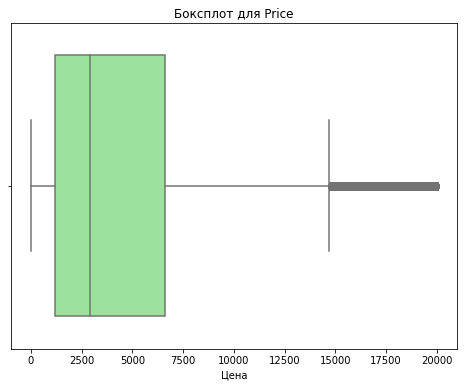

In [33]:
# Построим боксплот
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Price'], color='lightgreen')
           
plt.title('Боксплот для Price')
plt.xlabel('Цена')
plt.show

Присутсвуют выбросы после 1500, но оставим их.

In [34]:
# Удалим ненужные параметры
df.drop(columns=['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1, inplace=True)

In [35]:
# Проверим снова на дубликаты
df.duplicated().sum()

65342

In [36]:
# Удалим дубликаты и сбросим старую индексикацию
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

**Выводы:**
- Были проверены и удалены дубликаты.
- Были обнаружены пропуски в `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`, где пропуски были заменены на `other` в `VehicleType`, `Model`, `FuelType`, `Repaired`, и на `unknown` в `Gearbox`.
- Были ограничены значения параметра `Power` между 25 и 1000 л.с.
- Были огранечены значения параметра `RegistrationYear` между 1900 и 2016. Затем `DateCrawled` и `RegistrationYear` были переведены в формат даты с помощью to_datetime, чтобы найти их разницу и добавить новый признак `Age` с категорями 'new', 'fresh', 'used', 'used +', 'old', 'retro', после изучения распределения `Age`.
- Была удалена 0.05 нижней квантили параметра `Price`.
- Были удалены ненужные признаки, которые никак не влияют на целевой - `DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`.
- Были проверены и удалены дубликаты.

<a id='подготовка'></a>
## Подготовка данных

Модель LinearRegression требует кодировки категориальных данных с помощью One-Hot Encoding (OHE) и масштабирования числовых данных с помощью StandardScaler, потому что она чувствительна к масштабу признаков и не работает с категориальными переменными в текстовом формате.

In [37]:
# Отделим таргет от целевой переменной
X = df.drop('Price', axis=1)
y = df['Price']

# Закодируем номинальные категориальные данные с помощью OneHotEncoder
# Создаем лист из категориальных праметров
categorical_features = ['VehicleType', 'Age', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

# Создаем список из числовых признаков
numerical_features = ['Power', 'Kilometer']

# Разделяем данные на обучающую и тестовую выборки (test_size=0.25)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

ohe_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Кодируем только на train, затем transform для test
X_train_ohe = ohe_encoder.fit_transform(X_train[categorical_features])
X_test_ohe = ohe_encoder.transform(X_test[categorical_features])

# Преобразуем в DataFrame
X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_encoder.get_feature_names(), index=X_train.index)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_encoder.get_feature_names(), index=X_test.index)

# Удаляем старые категориальные признаки и добавляем закодированные
X_train_linear = X_train.drop(columns=categorical_features)
X_test_linear = X_test.drop(columns=categorical_features)

X_train_linear = pd.concat([X_train_linear, X_train_ohe], axis=1)
X_test_linear = pd.concat([X_test_linear, X_test_ohe], axis=1)

# Стандартизация числовых признаков
scaler = StandardScaler()
X_train_linear[numerical_features] = scaler.fit_transform(X_train_linear[numerical_features])
X_test_linear[numerical_features] = scaler.transform(X_test_linear[numerical_features])

In [38]:
# OrdinalEncoder для моделей деревьев
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Кодируем train и transform для test
X_train_oe = X_train.copy()
X_test_oe = X_test.copy()

X_train_oe[categorical_features] = ordinal_encoder.fit_transform(X_train[categorical_features])
X_test_oe[categorical_features] = ordinal_encoder.transform(X_test[categorical_features])

<a id='обучение'></a>
## Обучение моделей

**Модель Linear Regression**

In [39]:
# Обучим модель линейной регрессии и замерим время
start_time = time.time()
model_lr = LinearRegression()
model_lr.fit(X_train_linear, y_train)
train_time_lr = time.time() - start_time

# Время предсказания
start_time = time.time()
y_pred = model_lr.predict(X_train_linear)
predict_time_lr = time.time() - start_time

# Создаем кастомную метрику RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# # RMSE на кросс-валидации 
cv_scores_lr = cross_val_score(model_lr, X_train_linear, y_train, cv=5, scoring=rmse_scorer)
cv_rmse_lr = np.mean(cv_scores_lr)

# Вывод результатов
print(f"Время обучения: {train_time_lr:.2f} сек")
print(f"Время предсказания: {predict_time_lr:.2f} сек")
print(f"Среднее RMSE на кросс-валидации: {cv_rmse_lr:.2f}")

Время обучения: 19.93 сек
Время предсказания: 0.20 сек
Среднее RMSE на кросс-валидации: 27560660200.31


Какой-то нереальный показатель средней RMSE...

**Модель RandomForestRegressor**

In [40]:
# Замеряем время обучения
start_time = time.time()

# Испозуем сперва RandomForestRegressor с параметрами по умолчанию
rf = RandomForestRegressor(random_state=12345, n_jobs=-1)
rf.fit(X_train_oe, y_train)
train_time_rf = time.time() - start_time

# Замеряем время предсказания
start_time = time.time()
rf.predict(X_train_oe)
pred_time_rf = time.time() - start_time

# Оценка качества модели
# Кросс-валидация RMSE
cv_scores_rfr = cross_val_score(rf, X_train_oe, y_train, cv=5, scoring=rmse_scorer)
cv_rmse_rfr = np.mean(cv_scores_rfr)

print(f"Время обучения: {train_time_rf:.2f} сек")
print(f"Время предсказания: {pred_time_rf:.2f} сек")
print(f"RMSE: {cv_rmse_rfr:.2f}")

Время обучения: 46.48 сек
Время предсказания: 8.36 сек
RMSE: 1947.65


Тут у RandomForestRegressor дела получше, RMSE: 1947.65, что ниже 2500.

**Модель LightGBM**

In [41]:
# Определяем модель
model_lgbmr = LGBMRegressor()

# Гиперпараметры для подбора
parameters = {
    'num_leaves': [100, 150],  
    'learning_rate': [0.2, 0.4, 0.5, 0.8],  
    'random_state': [12345]
}

# Подбор гиперпараметров
clf = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Замер времени обучения GridSearch
start_time = time.time()
clf.fit(X_train_oe, y_train)
gridsearch_time_gbm = time.time() - start_time

# Вывод лучших параметров
best_params_gbm = clf.best_params_
print(f"Лучшие параметры: {best_params_gbm}")
print(f"Время подбора гиперпараметров: {gridsearch_time_gbm:.2f} сек")

Лучшие параметры: {'learning_rate': 0.2, 'num_leaves': 150, 'random_state': 12345}
Время подбора гиперпараметров: 2123.63 сек


In [42]:
# Обучение модели с найденными параметрами
best_model = LGBMRegressor(**best_params_gbm)

start_train_time = time.time()
best_model.fit(X_train_oe, y_train)
train_time_gbm = time.time() - start_train_time

# Замер времени предсказания
start_pred_time = time.time()
best_model.predict(X_train_oe)
pred_time_gbm = time.time() - start_pred_time

# Оценка качества модели
# Кросс-валидация RMSE
cv_scores_gbm = cross_val_score(best_model, X_train_oe, y_train, cv=5, scoring=rmse_scorer)
cv_rmse_gbm = np.mean(cv_scores_gbm)


print(f"Время обучения модели: {train_time_gbm:.2f} сек")
print(f"Время предсказания: {pred_time_gbm:.2f} сек")
print(f"RMSE модели LightGBM: {cv_rmse_gbm:.2f}")

Время обучения модели: 9.40 сек
Время предсказания: 1.81 сек
RMSE модели LightGBM: 1865.20


<a id='анализ'></a>
## Анализ моделей

Создадим таблицу для сравнения моделей по критериям.

In [43]:
# Устанавливаем формат отображения чисел с плавающей точкой
pd.set_option('display.float_format', '{:.2f}'.format)  # 2 знака после запятой

# Данные
data = {
    "Модель": ["Linear Regression", "RandomForestRegressor", "LightGBM"],
    "Время обучения (сек)": [train_time_lr, train_time_rf, train_time_gbm],
    "Время предсказания (сек)": [predict_time_lr, pred_time_rf, pred_time_gbm],
    "RMSE": [cv_rmse_lr, cv_rmse_rfr, cv_rmse_gbm]
}

# Создание таблицы
data_df= pd.DataFrame(data)
data_df

,Модель,Время обучения (сек),Время предсказания (сек),RMSE
0,Linear Regression,19.93,0.20,27560660200.31
1,RandomForestRegressor,46.48,8.36,1947.65
2,LightGBM,9.40,1.81,1865.20


**Качество предсказания (RMSE):**

- Наилучшее качество демонстрирует модель LightGBM с RMSE 1865.20.
- RandomForestRegressor незначительно уступает LightGBM, показывая RMSE 1947.65.
- Модель Linear Regression демонстрирует значительно худшее качество (RMSE 27560660200.31) и, следовательно, неприемлема для данной задачи.

**Время обучения:**

- Самая быстрая модель — LightGBM (7.59	 сек).
- Linear Regression (19.18 сек) обучается быстрее, чем RandomForestRegressor (40.62 сек).

**Время предсказания:**

- Linear Regression работает быстрее всех (0.11 сек), но из-за низкого качества предсказаний это не даёт преимуществ.
- LightGBM предсказывает в 4 раза быстрее, чем RandomForestRegressor (1.80 сек против 7.15 сек).

По критериям заказчика (качество предсказания, скорость предсказания, время обучения) наилучшей моделью является LightGBM. Linear Regression не подходит, так как RMSE слишком высокое. RandomForestRegressor показывает хороший результат, но проигрывает LightGBM по скорости предсказания и обучению.

In [44]:
# Теперь сделаем предсказание на основе тестовых данных и посмотрим на RMSE
y_pred_test = best_model.predict(X_test_oe)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
f"RMSE на тестовых данных: {rmse_test:.2f}"

'RMSE на тестовых данных: 1853.32'

Отлично, это удовлетворяет условие задачи RMSE < 2500. Теперь посмотрим на важность признаков.

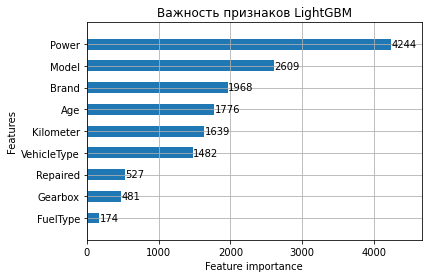

In [45]:
# Важность признаков
plot_importance(best_model, height=0.5)
plt.title('Важность признаков LightGBM')
plt.show()

- Лидирующий параметр `Power`
- Далее по убываниб с небольшим отрывом идут признаки: `Model`, `Brand`, `Age`, `Kilometer`, `VehicleType`.
- Наименее важные признаки `Repaired`, `Gearbox`, `FuelType`.

<a id='общий'></a>
## Общий вывод

В ходе исследования был проведен анализ данных о продаже подержанных автомобилей с целью разработки модели для определения их рыночной стоимости.

**Предобработка данных:**

- Выявлены и обработаны пропуски в признаках `VehicleType`, `Gearbox`, `Model`, `FuelType` и `Repaired` путем заполнения их значениями 'other' или 'unknown'.
- Обработаны выбросы в признаках `Power` (ограничение сверху до 1000 л.с.) и `Price` (удаление 0.05 нижней квантили), учитывая, что максимальные значения могли быть корректными, но редкими случаями.
- Проверены и удалены выбросы в `RegistrationYear` (значения до 1900 и после 2016 года).
- На основе `RegistrationYear` и `DateCrawled` (год скачивания анкеты) был создан новый признак `Age` (возраст автомобиля), категоризированный на группы 'new', 'fresh', 'used', 'used +', 'old' и 'retro' после изучения распределения возраста. 
- Для дальнейшего анализа были удалены неинформативные признаки, такие как `DateCrawled`, `RegistrationYear`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode` и `LastSeen`.
- Дубликаты записей были проверены и удалены.

**Обучение моделей:**

- Данные были разделены на обучающую и тестовую выборки в соотношении 75:25.
- Для обучения и анализа были использованы модели `Linear Regression`, `RandomForestRegressor` и `LightGBM`.
- Для `Linear Regression` было применено `One-Hot Encoding` категориальных признаков и масштабирование числовых признаков.
- Для `RandomForestRegressor` использовано кодирование категориальных признаков.
- Модель `LightGBM` обучалась на категориальных признаках, приведенных к типу category.

**Анализ моделей и результаты:**

- *Качество предсказания (RMSE)*: Лучшее качество показала модель `LightGBM (RMSE 1865.20)`, незначительно опередив `RandomForestRegressor (RMSE 1947.65)`. `Linear Regression` показала неприемлемо высокий `RMSE (27560660200.31)`.
- *Время обучения*: `LightGBM` обучается быстрее всего (7.59 сек), опережая `RandomForestRegressor` (40.62 сек) и `Linear Regression` (19.18 сек).
- *Время предсказания*: `Linear Regression` предсказывает быстрее всех (0.11 сек), однако, учитывая низкое качество, это преимущество нерелевантно. `LightGBM` предсказывает значительно быстрее (1.80 сек), чем `RandomForestRegressor` (7.15 сек).
- На тестовых данных модель `LightGBM` показала `RMSE 1853.32`.

**Важность признаков (LightGBM):**

- Наиболее важным признаком оказался `Power`, за которым с небольшим отрывом следуют `Model`, `Brand`, `Age`, `Kilometer` и `VehicleType`. Наименее важными признаками оказались `Repaired`, `Gearbox` и `FuelType`.

**Вывод и рекомендации:**

По критериям заказчика (качество предсказания, скорость предсказания и время обучения) наилучшей моделью для предсказания стоимости автомобилей является `LightGBM`.  Модель удовлетворяет требованиям по `RMSE (< 2500)` и демонстрирует высокую скорость обучения и предсказания. Рекомендуется использовать LightGBM для решения поставленной задачи.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей